<h1 style="text-align: center">Tokenizing the text of the raw IMDB Data using Keras API</h1>

In [3]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense

import matplotlib.pyplot as plt
import numpy as np
import os
import emoji 

In [2]:
! tree -L 2 imdb/

imdb/
├── test
│   ├── neg
│   ├── pos
│   ├── urls_neg.txt
│   └── urls_pos.txt
└── train
    ├── neg
    ├── pos
    ├── urls_neg.txt
    └── urls_pos.txt

6 directories, 4 files


## Processing the labels of the raw IMDB data

In [3]:
imdb_dir = 'imdb'
train_dir = os.path.join(imdb_dir, 'train')
labels = []
texts = []
for label_type in ['neg', 'pos']:
    dir_name = os.path.join(train_dir, label_type)
    for fname in os.listdir(dir_name):
        if fname[-4:] == '.txt':
            f = open(os.path.join(dir_name, fname))
            texts.append(f.read())
            f.close()
        if label_type == 'neg':
            labels.append(0)
        else:
            labels.append(1)

## TOKENIZING THE DATA 

<ol>
    <li> <b> Tokenizer(num_words = 100) : </b> maximum সে ১০০ টি word এর indexing করবে( frequency number store করবে )</li>
  <li> <b> fit_on_texts : </b> এখানে String গুলোর indexing করবে </li>
    <li> <b> texts_to_sequences : </b>  তৈরীকৃত indexing এর একটা লিস্ট return করবে</li>
</ol>

In [4]:
maxlen = 100
training_samples = 200
validation_samples = 10000
max_words = 10000
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

<ol>
    <li> <b>  tokenizer.word_index  : </b> Unique word গুলো return করবে </li>
  <li> <b> pad_sequences : </b> আমাদের যে sequence ছিল সেটিকে padding করবে from right side যদি efficient না হয় তাহলে ০ দিয়ে fill করবে </li>
    <li> <b> np.asarray : </b> label কে 1D flatten করবে </li>
</ol>

In [5]:
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))
data = pad_sequences(sequences, maxlen=maxlen)
labels = np.asarray(labels)
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

Found 88582 unique tokens.
Shape of data tensor: (25000, 100)
Shape of label tensor: (25000,)


<ol>
    <li> <b>  Shuffling : </b> data(unique word এর vector) & label কে shuffling করতে হবে  </li>
  <li> <b>  np.arange : </b> data.shape[0] মানে total sentence/file/ প্রথম shape নেওয়া। যদি shape = 25000 হয় তার মানে তার ডাটাও আছে ২৫০০০০ এবং label ও আছে ২৫০০০০। যে গুলোকে আমরা shuffling করব using np.random.shuffle() </li>
    <li> <b> np.asarray : </b> label কে 1D flatten করবে </li>
</ol>

In [6]:
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]

<ol>
    <li> <b>  x_train : </b> data[:200] মানে ২০০ টা file / sentence নিয়ে train করব   </li>
  <li> <b>  y_train : </b> labels[:200]  মানে ২০০ টা file / sentence এর label / output  </li>
    <li> <b> x_val : </b>data[200: 200 + 10000] মানে 200 থেকে 10200(10000) পর্যন্ত test জন্য যাবে  </li>
     <li> <b> y_val : </b>labels[200: 200 + 10000] মানে 200 থেকে 10200(10000) পর্যন্ত labels জন্য  </li>
</ol>

In [7]:
x_train = data[:training_samples]
y_train = labels[:training_samples]
x_val = data[training_samples: training_samples + validation_samples]
y_val = labels[training_samples: training_samples + validation_samples]

print(len(x_train))
print(len(y_train))
print(len(x_val))
print(len(y_val))

200
200
10000
10000


<h1 style="text-align: center"> Grabbing glove word embedding file data</h1>

In [8]:
glove_dir = 'glove.6B'
embeddings_index = {}
f = open(os.path.join(glove_dir, 'glove.6B.100d.txt'))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


## Preparing the GloVe word-embeddings matrix

<ol>
    <li> <b>  embedding_matrix : </b> IMDB final dimention ছিল 10000X100(10000 words and 100 coeficient / length).   <br> আমাদের যে IMDB এর word ছিল তাদের সবগুলোর  মান/coeficient এখন glove word থেকে নিব :)    </li>
</ol>

In [9]:
embedding_dim = 100
embedding_matrix = np.zeros((max_words, embedding_dim)) 
for word, i in word_index.items():
    if i < max_words:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

## Model definition

<ol>
    <li> <b>  Embedding(10000X100X100) : </b>embedding_matrix shape ছিল 10000X100 যেটিকে input_shape = 1000X100X100 করা হল <br>  যেখানে samples / batch_size =10000, input_size = (100X100) <br>
   So, এখানে param = 10000*100, output_shape = 100</li>
    <li> <b>Flatten() : </b> Embedding এ 10000*100*100   </li>
</ol>

In [24]:
model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen)) # 10000X100X100
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_14 (Embedding)     (None, 100, 100)          1000000   
_________________________________________________________________
flatten_14 (Flatten)         (None, 10000)             0         
_________________________________________________________________
dense_27 (Dense)             (None, 32)                320032    
_________________________________________________________________
dense_28 (Dense)             (None, 1)                 33        
Total params: 1,320,065
Trainable params: 1,320,065
Non-trainable params: 0
_________________________________________________________________


In [15]:
from keras.utils import plot_model

model5 = Sequential()
model5.add(Embedding(input_dim=4, output_dim=3, input_length=10)) 
model5.add(Flatten())
model5.add(Dense(2, activation='relu'))
model5.add(Dense(1, activation='sigmoid'))
model5.summary()
plot_model(model5,  to_file='cnn_model.png', show_shapes=True, show_layer_names=True, rankdir='LR')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 10, 3)             12        
_________________________________________________________________
flatten_8 (Flatten)          (None, 30)                0         
_________________________________________________________________
dense_18 (Dense)             (None, 2)                 62        
_________________________________________________________________
dense_19 (Dense)             (None, 1)                 3         
Total params: 77
Trainable params: 77
Non-trainable params: 0
_________________________________________________________________


## LOADING THE GLOVE EMBEDDINGS IN THE MODEL
#### Transfer learning: অামরা pretrained / known weight কে use করল ফলে সে ভালো শিখতে পারবে। এটি Comments out করে check করা যেতে পারে।

In [36]:
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False

## TRAINING AND EVALUATING THE MODEL

In [37]:
model.compile(optimizer='rmsprop',
loss='binary_crossentropy',
metrics=['acc'])
history = model.fit(x_train, y_train,
epochs=10,
batch_size=32,
validation_data=(x_val, y_val))
model.save_weights('pre_trained_glove_model.h5')

Train on 200 samples, validate on 10000 samples
Epoch 1/10
200/200 [==============================] - 1s 3ms/step - loss: 7.2244 - acc: 0.5350 - val_loss: 8.0033 - val_acc: 0.4983
Epoch 2/10
200/200 [==============================] - 0s 2ms/step - loss: 7.7644 - acc: 0.4700 - val_loss: 5.0746 - val_acc: 0.5044
Epoch 3/10
200/200 [==============================] - 0s 2ms/step - loss: 4.2851 - acc: 0.5600 - val_loss: 2.1635 - val_acc: 0.5242
Epoch 4/10
200/200 [==============================] - 0s 2ms/step - loss: 1.2051 - acc: 0.6800 - val_loss: 1.4315 - val_acc: 0.5199
Epoch 5/10
200/200 [==============================] - 0s 2ms/step - loss: 0.4034 - acc: 0.8500 - val_loss: 3.3151 - val_acc: 0.5030
Epoch 6/10
200/200 [==============================] - 0s 2ms/step - loss: 0.9387 - acc: 0.6850 - val_loss: 1.1435 - val_acc: 0.5486
Epoch 7/10
200/200 [==============================] - 0s 2ms/step - loss: 0.1052 - acc: 0.9650 - val_loss: 1.0225 - val_acc: 0.5565
Epoch 8/10
200/200 [========

## Plotting the results

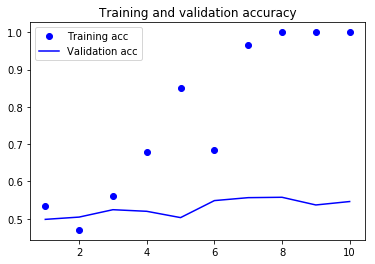

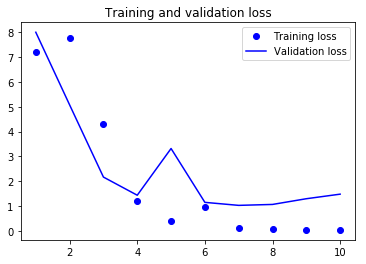

In [38]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

## Training the same model without pretrained word embeddings

In [39]:
model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()
model.compile(optimizer='rmsprop',
loss='binary_crossentropy',
metrics=['acc'])
history = model.fit(x_train, y_train,
epochs=10,
batch_size=32,
validation_data=(x_val, y_val))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_17 (Embedding)     (None, 100, 100)          1000000   
_________________________________________________________________
flatten_17 (Flatten)         (None, 10000)             0         
_________________________________________________________________
dense_33 (Dense)             (None, 32)                320032    
_________________________________________________________________
dense_34 (Dense)             (None, 1)                 33        
Total params: 1,320,065
Trainable params: 1,320,065
Non-trainable params: 0
_________________________________________________________________
Train on 200 samples, validate on 10000 samples
Epoch 1/10
200/200 [==============================] - 1s 4ms/step - loss: 0.6979 - acc: 0.4450 - val_loss: 0.6917 - val_acc: 0.5195
Epoch 2/10
200/200 [==============================] - 0s 2ms/step - loss: 0.5115 - a

## Ploting the results

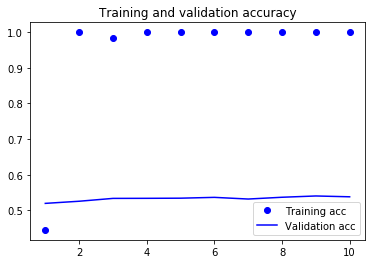

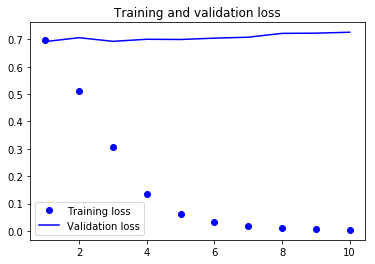

In [40]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

## Tokenizing the data of the test set

In [34]:
test_dir = os.path.join(imdb_dir, 'test')
labels = []
texts = []
for label_type in ['neg', 'pos']:
    dir_name = os.path.join(test_dir, label_type)
    for fname in sorted(os.listdir(dir_name)):
        if fname[-4:] == '.txt':
            f = open(os.path.join(dir_name, fname))
            texts.append(f.read())
            f.close()
            if label_type == 'neg':
                labels.append(0)
            else:
                labels.append(1)
                
sequences = tokenizer.texts_to_sequences(texts)
x_test = pad_sequences(sequences, maxlen=maxlen)
y_test = np.asarray(labels)

## Evaluating the model on the test set

In [41]:
model.load_weights('pre_trained_glove_model.h5')
model.evaluate(x_test, y_test)

25000/25000 [==============================] - 1s 39us/step


[1.4888060511207581, 0.53484]